In [1]:
import os
import numpy as np

dataset_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/QM9_smi_datasets/train_test_dataset_100000.smi"
json_cache_location = os.environ["DATA"] + "/00_datasets/DFT/QM9/cache_QM9.json"

output_results_path = os.environ["DATA"] + "/07_BBO/02_models/paper/02.04_GPR_HOMO_QM9_data_efficiency_larger_test_set_size_1000_whitek/"
output_figures_path = os.environ["FIGURES"] + "/07_BBO/02_models/paper/02.04_GPR_HOMO_QM9_data_efficiency_larger_test_set_size_1000_whitek/"

# dft_path = os.environ["DFT_COMPUT_RDKIT_MM"]

TOTAL_DATASET_SIZE = 10000
N_MOL = [10, 30, 50, 100, 300, 500, 1000]

CV_EXTERNAL = 10

N_JOBS=10

MM_program = "rdkit"

models_to_run = {
#     ("1.0*SOAP( xi=2)", "SOAP"): [1e-1, 1e0],
    ("1.0*RBF( 1.0)", "MBTR"): [1e-10],
#     ("1.0*DotProduct( sigma_0=1)", "MBTR"): [1e-2, 1e-1],
    ("1.0*DotProduct( sigma_0=1)", "Shingles count"): [1e-10]
}

dft_path = "/tmp"

In [2]:
from bbomol.objective import EvoMolEvaluationStrategyWrapper
from evomol.evaluation_dft import OPTEvaluationStrategy

objective = EvoMolEvaluationStrategyWrapper(
    OPTEvaluationStrategy("homo", n_jobs=2, cache_files=[json_cache_location], 
                          working_dir_path=dft_path,
                          MM_program=MM_program))

DFT MM rdkit
133798 molecules in cache


In [3]:
from os import makedirs

makedirs(output_results_path, exist_ok=True)
makedirs(output_figures_path, exist_ok=True)

In [4]:
import numpy as np
from sklearn.gaussian_process.kernels import StationaryKernelMixin, NormalizedKernelMixin, Kernel

class SOAPKernelVectorized(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    
    def __init__(self, xi=2):
        self.xi = xi
        
    def __call__(self, X, Y=None, eval_gradient=False):
        
        if Y is None:
            Y = X
            
        # Extracting the dimensions of both matrices
        X_dim = X.shape[0]
        Y_dim = Y.shape[0]

        # Computing the dot product of each matrix with itself and with the other
        dot_X_X = X.dot(X.T)
        dot_X_Y = X.dot(Y.T)
        dot_Y_Y = Y.dot(Y.T)

        # Extracting the dot product of each element of each matrix with itself
        diag_X = np.diag(dot_X_X)
        diag_Y = np.diag(dot_Y_Y)

        # Building the matrix of dimension (X_dim, Y_dim) containing in each line the dot product of the nth
        # element of X with itself
        X_dot_matrix = np.tile(diag_X, Y_dim).reshape((Y_dim, X_dim)).T

        # Building the matrix of dimension (X_dim, Y_dim) containing in each column the dot product of the nth
        # element of Y with itself
        Y_dot_matrix = np.tile(diag_Y, X_dim).reshape((X_dim, Y_dim))

        # Computing the SOAP kernel of X and Y
        K = (dot_X_Y/np.sqrt(X_dot_matrix * Y_dot_matrix))**self.xi
        
        if np.sum(np.isinf(K)) > 0:
            print("Inf values in kernel")
            
        if np.sum(np.isnan(K)) > 0:
            print("Nan values in kernel")
        
        # Replacing possible nan values due to zero by zero division
        K[np.isnan(K)] = 0
        
        if eval_gradient:
            return K, np.empty((X.shape[0], X.shape[0], 0))
        else:
            return K
    

    def get_params(self, deep=True):
        return {"xi": self.xi}
    
    def __repr__(self):
        return "{0}(xi={1:.3g})".format(self.__class__.__name__, self.xi)


In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern, RationalQuadratic, DotProduct, WhiteKernel


kernels = [("1.0*RBF( 1.0)", 1.0*RBF(1.0) + WhiteKernel(1.0)),
           ("1.0*DotProduct( sigma_0=1)", 1.0*DotProduct(sigma_0=1) + WhiteKernel(1.0)),
           ("1.0*SOAP( xi=2)", 1.0*SOAPKernelVectorized(xi=2))]


models = []
for kernel in kernels:
    models.append((kernel[0], GaussianProcessRegressor(kernel=kernel[1],
                                                       optimizer="fmin_l_bfgs_b", normalize_y=True)))


In [6]:
from chemdesc import SOAPDesc, ShinglesVectDesc, MBTRDesc, CoulombMatrixDesc

descriptors_mm = [
#     ("SOAP", SOAPDesc(cache_location=None, n_jobs=N_JOBS, average="inner", rcut=4, nmax=5, 
#                       lmax=6, species=["C", "H", "O", "N", "F"], MM_program=MM_program)),
    ("MBTR", MBTRDesc(cache_location=None, n_jobs=N_JOBS, cosine_angles_n=25, atomic_numbers_n=10, 
                      inverse_distances_n=25, species=["C", "H", "O", "N", "F"], MM_program=MM_program)), 
    ("Shingles count", ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)),
#     ("CM", CoulombMatrixDesc(n_atoms_max=29, cache_location=None, n_jobs=N_JOBS, MM_program=MM_program)),
]
    

MM program : rdkit
species MBTR  : ['C', 'H', 'O', 'N', 'F']
atomic_numbers_n : 10
inverse_distances_n : 25
cosine_angles_n : 25
MM program : obabel_mmff94


In [7]:
from os.path import join
import numpy as np
from sklearn.preprocessing import normalize, scale


def compute_desc_obj(smiles_list, desc_builder, objective):
    
    X, success = desc_builder.transform(smiles_list)
    X = X[success]
    
    smiles_list_filtered = np.array(smiles_list)[success]
    
    y, all_scores, success, comput_times = objective.transform(smiles_list_filtered)
    
    smiles_list_filtered = np.array(smiles_list_filtered)[success]
    
    return X[success], y[success], smiles_list_filtered
    

In [8]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from os.path import join
import json

def train_models_alpha_value(X, y, desc_name, model_name, model, preprocessing, geometry_type, dataset_size, 
                             alpha_value, output_path):
    
    experiment_name = desc_name + "-" + model_name + "-" + str(preprocessing) + "-" + geometry_type + "-" + str(dataset_size) + "-" + str(alpha_value)
    experiment_output_json = join(output_path, experiment_name + ".json")

    if preprocessing is not None:
        pipeline = Pipeline([
            ("Preprocessing", preprocessing),
            ("model", model)
        ])
    else:
        pipeline = Pipeline([
            ("model", model)
        ])

    # Setting scoring metrics
    scoring = {
        "MAE": "neg_mean_absolute_error",
        "RMSE": "neg_root_mean_squared_error"
    }
    
    # Setting alpha value to the model
    pipeline.set_params(
        model__alpha = alpha_value,
    )
    
    print(pipeline)
    

    # Performing cross validation (external CV)
    scores = cross_validate(estimator=pipeline, X=X, y=y, scoring=scoring,
                            cv=ShuffleSplit(n_splits=CV_EXTERNAL, train_size=dataset_size, random_state=42), 
                            n_jobs=N_JOBS, verbose=3, return_estimator=True)

    print(scores)

    # Computing output dictionary
    output_dict = {
        "exp_name": experiment_name,
        "mean_mae": float(- scores["test_MAE"].mean()),
        "mae_values": (- scores["test_MAE"]).tolist(),
        "mean_rmse": float(- scores["test_RMSE"].mean()),
        "rmse_values": (- scores["test_RMSE"]).tolist(),
        "mean_fit_time": scores["fit_time"].mean(),
        "fit_times": scores["fit_time"].tolist(),
        "mean_score_time": scores["score_time"].mean(),
        "score_times": scores["score_time"].tolist()
    }
    
    print(output_dict)

    # Writing output json file to disk
    with open(experiment_output_json, "w") as f:
        json.dump(output_dict, f, indent=4)


def train_models_dataset_size(models, X, y, descriptor_name, objective, dataset_path, output_path, 
                              geometry_type, dataset_size, preprocessing=None):
    
        
    # Iteration over all models
    for model_tuple in models:

        model_name, model = model_tuple

        # Checking that experiment must be run
        if (model_name, descriptor_name) in models_to_run:

            # Extracting alpha values for given model
            alpha_values = models_to_run[(model_name, descriptor_name)]

            # Iterating over alpha values
            for alpha_value in alpha_values:

                # Performing experiments for given dataset size and alpha value
                train_models_alpha_value(X=X, y=y, desc_name=descriptor_name, model_name=model_name, 
                                         model=model, preprocessing=preprocessing, 
                                         geometry_type=geometry_type, dataset_size=dataset_size, 
                                         alpha_value=alpha_value, output_path=output_path)

                
                
def train_all_models(models, descriptors, objective, dataset_path, output_path, geometry_type, dataset_sizes, 
                     preprocessing):
    
    # Extracting required number of SMILES
    total_smiles_list = []
    with open(dataset_path, "r") as f:
        for smi in f.readlines()[:TOTAL_DATASET_SIZE]:
            total_smiles_list.append(smi.rstrip())
    
    # Iterating over all descriptors
    for descriptor_tuple in descriptors:
        
        desc_name, desc_builder = descriptor_tuple
                
        # Computing descriptors and objective values for current descriptor 
        X, y, smiles_list_filtered = compute_desc_obj(total_smiles_list, desc_builder, objective)
    
        # Iterating over all dataset sizes
        for dataset_size in dataset_sizes:
            train_models_dataset_size(models=models, descriptor_name=desc_name, X=X, y=y, 
                                      objective=objective, dataset_path=dataset_path, 
                                      output_path=output_path, geometry_type=geometry_type, 
                                      dataset_size=dataset_size, preprocessing=preprocessing)

In [9]:
train_all_models(models=models, descriptors=descriptors_mm, objective=objective, dataset_path=dataset_path, 
                 output_path=output_results_path, geometry_type="MM", dataset_sizes=N_MOL, preprocessing=None)

100%|██████████| 10000/10000 [01:16<00:00, 131.32it/s]


Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.8s remaining:    1.8s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'fit_time': array([0.27279496, 0.28756714, 0.27411556, 0.32027745, 0.3015449 ,
       0.24933481, 0.25974035, 0.26033711, 0.25715089, 0.22428107]), 'score_time': array([0.39774132, 0.43577194, 0.38162518, 0.38061357, 0.39318919,
       0.39807463, 0.39700437, 0.39621043, 0.44170809, 0.38178611]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.9s remaining:    2.2s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'fit_time': array([0.2560761 , 0.31672764, 0.35134029, 0.49951053, 0.36034012,
       0.23821712, 0.25585127, 0.265553  , 0.25393748, 0.45589018]), 'score_time': array([0.51178932, 0.58919549, 0.55473614, 0.44191527, 0.54980826,
       0.59660077, 0.60007548, 0.57113886, 0.61183405, 0.4106524 ]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    1.6s remaining:    3.8s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'fit_time': array([0.34767127, 0.40876055, 0.32933784, 0.29810977, 0.32426977,
       0.35210085, 0.29525948, 0.36529827, 0.36517787, 0.36937785]), 'score_time': array([1.28416133, 1.30719686, 1.3075521 , 1.15546632, 1.21291685,
       1.35221219, 1.40142941, 1.15031958, 1.24135733, 1.27732468]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    3.2s remaining:    7.4s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    3.6s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    3.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'fit_time': array([0.42020702, 0.75237036, 0.63251185, 0.65031695, 0.54633665,
       0.56277823, 0.55067587, 0.53718305, 0.53692794, 0.83762574]), 'score_time': array([1.7406292 , 2.01330256, 2.90921879, 2.83712769, 2.54187059,
       2.99907398, 2.96546173, 2.99643421, 2.64154363, 2.76020312]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   16.8s remaining:   39.3s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:   17.7s remaining:    7.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'fit_time': array([4.83220291, 4.61646962, 3.6360755 , 4.92295003, 5.18309307,
       4.19723749, 4.53223515, 4.63518357, 5.11416745, 5.02756   ]), 'score_time': array([12.77031636, 12.12591839, 13.3943038 , 12.10743856, 12.5366385 ,
       11.32198071, 12.93273878, 12.99322391, 12.58268476, 10.91641021]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          k

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   33.2s remaining:  1.3min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:   33.9s remaining:   14.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   34.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'fit_time': array([14.89693117, 13.84279323, 11.51301408, 13.9960463 , 16.16649556,
       13.94556832, 13.24032235, 15.47931695, 13.64467597, 16.18812633]), 'score_time': array([18.90512633, 19.36964989, 16.76336956, 19.70741963, 18.51189685,
       17.94684553, 20.51790047, 18.50879097, 19.45584798, 18.49354315]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                 

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:  1.7min remaining:  4.0min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:  1.7min remaining:   44.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.8min finished
  0%|          | 43/10000 [00:00<00:23, 428.02it/s]

{'fit_time': array([67.63421082, 66.87722659, 60.59934783, 58.9768579 , 60.75824261,
       61.79568624, 61.50767779, 65.58091331, 68.14706159, 63.27820826]), 'score_time': array([36.8785007 , 37.81885767, 38.88977551, 40.81552339, 40.93879652,
       41.24631667, 41.41297054, 39.17878485, 36.98065829, 39.10700083]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                 

100%|██████████| 10000/10000 [00:22<00:00, 449.09it/s]


Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'fit_time': array([0.25725627, 0.26900721, 0.25068998, 0.25000954, 0.24991512,
       0.20407319, 0.24834156, 0.26807475, 0.22429109, 0.25990844]), 'score_time': array([0.08620691, 0.08363748, 0.12102365, 0.12619519, 0.11732244,
       0.08270383, 0.12393475, 0.11399865, 0.11167145, 0.10578012]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1*

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.5s remaining:    1.2s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'fit_time': array([0.27265024, 0.24205112, 0.27416515, 0.28709674, 0.29500866,
       0.20811391, 0.29065442, 0.27648878, 0.25398088, 0.29942632]), 'score_time': array([0.12569737, 0.0863657 , 0.12937069, 0.11993003, 0.11752844,
       0.10730934, 0.1146934 , 0.11705589, 0.12976217, 0.09651732]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1*

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'fit_time': array([0.26485419, 0.25627089, 0.27511454, 0.19478369, 0.30367136,
       0.27401543, 0.26626539, 0.31449056, 0.24438429, 0.25736547]), 'score_time': array([0.14370227, 0.14763117, 0.1560204 , 0.1435132 , 0.14271569,
       0.15652061, 0.15890479, 0.12854123, 0.15910888, 0.10330915]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1*

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.6s remaining:    1.4s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'fit_time': array([0.40626478, 0.32784677, 0.30925083, 0.31987906, 0.32142758,
       0.31732154, 0.36897469, 0.42097473, 0.36142468, 0.31673741]), 'score_time': array([0.21055746, 0.2322371 , 0.24345732, 0.24689198, 0.25179124,
       0.25307965, 0.13201213, 0.2054193 , 0.13324785, 0.24548268]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1*

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    1.7s remaining:    4.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    1.9s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'fit_time': array([1.39594364, 1.09744191, 1.46337628, 1.53021479, 1.01080537,
       0.95232487, 1.04960155, 0.97691536, 1.43318272, 1.07689238]), 'score_time': array([0.38726258, 0.35787129, 0.39281559, 0.38550401, 0.63665056,
       0.66093755, 0.64021826, 0.65270019, 0.4423945 , 0.35552549]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1*

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    4.1s remaining:    9.6s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    4.7s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    4.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'fit_time': array([3.82571197, 2.74434185, 2.32658601, 3.91323256, 4.21684861,
       1.38936067, 4.07831597, 3.74114633, 3.53664041, 3.67589164]), 'score_time': array([0.65581512, 1.27248597, 0.76406837, 0.73119807, 0.56187439,
       1.42331243, 0.68515754, 0.89677119, 0.64273381, 0.59186625]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1*

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   16.0s remaining:   37.4s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:   18.5s remaining:    7.9s


{'fit_time': array([ 9.66345763, 14.5055337 , 16.22187185, 17.34416509, 16.63051748,
       17.92504835, 17.18292499, 17.29400802, 12.24040151, 16.78232217]), 'score_time': array([3.13398027, 1.36095095, 1.36885428, 1.04319   , 1.33911943,
       0.81025791, 1.30350924, 1.09996629, 2.97776175, 1.27292204]), 'estimator': (Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False), Pipeline(memory=None,
         steps=[('model',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                         

[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   18.8s finished


In [10]:
import time

def comput_desc_time(descriptors, size):
    
    # Extracting required number of SMILES
    total_smiles_list = []
    with open(dataset_path, "r") as f:
        for smi in f.readlines()[:size]:
            total_smiles_list.append(smi.rstrip())
    
    for desc_tuple in descriptors:
        
        desc_name, desc_builder = desc_tuple
        desc_builder.n_jobs = 1

        tstart = time.time()
        desc_builder.fit_transform(total_smiles_list)
        time_comput = time.time() - tstart
        
        with open(join(output_results_path, desc_name + "-" + str(size) + ".txt"), "w") as f:
            f.writelines([str(time_comput)])

In [11]:
comput_desc_time(descriptors_mm, 100)
comput_desc_time(descriptors_mm, 500)
comput_desc_time(descriptors_mm, 1000)

100%|██████████| 1000/1000 [00:02<00:00, 453.23it/s]


In [12]:
def extract_desc_time(descriptors, size):
    
    fit_times = {}
    
    for desc_tuple in descriptors:
        
        desc_name, _ = desc_tuple
        
        path = join(output_results_path, desc_name + "-" + str(size) + ".txt")
        with open(path, "r") as f:
            fit_times[desc_name] = float(f.readline())
            
    return fit_times
    

In [13]:
desc_times_100 = extract_desc_time(descriptors_mm, 100)
desc_times_500 = extract_desc_time(descriptors_mm, 500)
desc_times_1000 = extract_desc_time(descriptors_mm, 1000)

print(desc_times_1000)

{'MBTR': 50.360356092453, 'Shingles count': 2.2082865238189697}


In [14]:
import json
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)


def init_results_dict(models, descriptors):
    
    results_dict = {}
    results_dict["kernel"] = [model[0] for model in models]
    for descriptor in descriptors:
        results_dict[descriptor[0]] = []
    
    return results_dict

def display_dict(name, d):
    display(HTML('<h3>' + name +'</h3>'))
    display(pd.DataFrame.from_dict(d))
    

def extract_results(json_path):
    
    with open(json_path, "r") as f:
        json_dict = json.load(f)
        
        mean_mae = json_dict["mean_mae"]
        mae_values = json_dict["mae_values"]
        mean_rmse = json_dict["mean_rmse"]
        rmse_values = json_dict["rmse_values"]
        mean_fit_time = json_dict["mean_fit_time"]
        fit_times = json_dict["fit_times"]
        
    return mean_mae, mae_values, mean_rmse, rmse_values, mean_fit_time, fit_times

    
def plot_values_subplot(mae_dict, time_dict):
    
    plt.xlim((0, 1))
    plt.ylim((1, 10000))
    plt.xlabel("MAE (eV)")
    plt.ylabel("time (s)")
    plt.yscale("log")
    
    pd_dict= {
        "x_values": [],
        "y_values": [],
        "kernel_values": [],
        "desc_values": [],
    }
    
    colors = sns.color_palette()
    markers = ['s', '^', 'o', '+', 'x']
    
    all_kernels = list(mae_dict["kernel"])
    all_desc = []
    for i, key in enumerate(mae_dict.keys()):
        
        if key != "kernel":
            
            all_desc.append(key)
            
            for j in range(len(kernels)):
                
                pd_dict["x_values"].append(mae_dict[key][j])
                pd_dict["y_values"].append(time_dict[key][j])
                pd_dict["kernel_values"].append(all_kernels[j])
                pd_dict["desc_values"].append(key)

        
    sns.scatterplot(data=pd_dict, x="x_values", y="y_values", hue="kernel_values", style="desc_values")
    
    

def extract_values(models, descriptors, results_root, geometry_type, preprocessing, dataset_sizes):
    
    results_dict = {}

    # Iterating over dataset sizes
    for dataset_size in dataset_sizes:
        
        results_dict[dataset_size] = {}
    
        # Iterating over all descriptors
        for desc_tuple in descriptors:

            desc_name, _ = desc_tuple
            
            results_dict[dataset_size][desc_name] = {
                "model": {}
            }
            
            # Iterating over all models
            for model_tuple in models:
                
                model_name, _ = model_tuple
                
                # Checking that there is data for current model
                if (model_name, desc_name) in models_to_run:
                    
                    results_dict[dataset_size][desc_name]["model"][model_name] = {}
                    
                    # Iterating over alpha values for current model
                    for i, alpha_value in enumerate(models_to_run[(model_name, desc_name)]):
                        
                        # Computing model path
                        experiment_name = desc_name + "-" + model_name + "-" + str(preprocessing) + "-" + geometry_type + "-" + str(dataset_size) + "-" + str(alpha_value)
                        path = join(output_results_path, experiment_name + ".json")
                        
                        # Extracting results
                        mean_mae, mae_values, mean_rmse, rmse_values, mean_fit_time, fit_times = extract_results(path)
                        
                        results_dict[dataset_size][desc_name]["model"][model_name][i] = {
                            "mean_mae": mean_mae,
                            "mae_values": mae_values,
                            "mean_rmse": mean_rmse,
                            "rmse_values": rmse_values,
                            "mean_fit_time": mean_fit_time,
                            "fit_times": fit_times
                        }

    return results_dict
             
    


# MM results 



In [15]:
results_dict = extract_values(models, descriptors_mm, output_results_path, "MM", None, N_MOL)

In [16]:
from IPython.display import display, HTML


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

def desc_kernel_to_model_name(desc_name, kernel_name):
    
    if desc_name == "Shingles count":
        desc = "Shingles"
    else:
        desc = desc_name

    if kernel_name == "1.0*SOAP( xi=2)":
        kernel = "SOAP"
    elif kernel_name == "1.0*RBF( 1.0)":
        kernel = "RBF"
    elif kernel_name == "1.0*DotProduct( sigma_0=1)":
        kernel = "·"
    
    return "GPR("+desc+", " + kernel +")"

def plot_data_efficiency(results_dict, desc_times_1000):
    
    pd_dict = {
        "Dataset size": [],
        "MAE (eV)": [],
        "RMSE (eV)": [],
        "Fit time (s)": [],
        "Fit + 1000 desc. time (s)": [],
        "Model": [],
        "Noise": [],
        "run": []
    }
    
    for dataset_size in results_dict.keys():
        
        for desc_name in list(results_dict[dataset_size].keys())[::-1]:
            
            for model_name in results_dict[dataset_size][desc_name]["model"].keys():
                
                for alpha_geom in results_dict[dataset_size][desc_name]["model"][model_name].keys():
                    
                    if alpha_geom == 0:
                
                        mae_values = results_dict[dataset_size][desc_name]["model"][model_name][alpha_geom]["mae_values"]
                        rmse_values = results_dict[dataset_size][desc_name]["model"][model_name][alpha_geom]["rmse_values"]
                        fit_times = results_dict[dataset_size][desc_name]["model"][model_name][alpha_geom]["fit_times"]
                        fit_times_desc_1000 = list(np.array(fit_times) + desc_times_1000[desc_name])
                        for i in range(CV_EXTERNAL):

                            pd_dict["Dataset size"].append(dataset_size)
                            pd_dict["MAE (eV)"].append(mae_values[i])
                            pd_dict["RMSE (eV)"].append(rmse_values[i])
                            pd_dict["Fit time (s)"].append(fit_times[i])
                            pd_dict["Fit + 1000 desc. time (s)"].append(fit_times_desc_1000[i])
                            pd_dict["run"].append(i)
                            pd_dict["Noise"].append("optimal noise 3000" + " * " + str(10**alpha_geom))
                            pd_dict["Model"].append(desc_kernel_to_model_name(desc_name, model_name))

    plt.figure(figsize=(7, 2))
    sns.lineplot(data=pd_dict, x="Dataset size", y="MAE (eV)", hue="Model")#, style="Noise")
    plt.ylim((0.2, 0.55))
    plt.xlim((10, 1000))
    plt.xscale("log") 
    plt.xlabel("Dataset size")
    plt.ylabel("MAE (eV)")
    plt.legend()
    plt.savefig(join(output_figures_path, "efficiency_MAE.png"), dpi=600, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(7, 5))
    sns.lineplot(data=pd_dict, x="Dataset size", y="RMSE (eV)", hue="Model")#, style="Noise")
    plt.ylim((0, 0.55))
    plt.xlim((10, 1000))
    plt.xscale("log")
    plt.xlabel("Dataset size")
    plt.ylabel("RMSE (eV)")
    plt.legend()
    plt.savefig(join(output_figures_path, "efficiency_RMSE.png"), dpi=600)
    
    plt.figure(figsize=(7, 5))
    sns.lineplot(data=pd_dict, x="Dataset size", y="Fit time (s)", hue="Model")#, style="Noise")
    plt.xlabel("Dataset size")
    plt.ylabel("Fit time (s)")
    plt.legend()
    plt.savefig(join(output_figures_path, "efficiency_time.png"), dpi=600)
    
    plt.figure(figsize=(7, 5))
    sns.lineplot(data=pd_dict, x="Dataset size", y="Fit + 1000 desc. time (s)", hue="Model")#, style="Noise")
    plt.xlabel("Dataset size")
    plt.ylabel("Fit + 1000 desc. time (s)")
    plt.legend()
    plt.savefig(join(output_figures_path, "efficiency_time_+_1000_desc.png"), dpi=600)
    
    
    
def display_times(results_dict, desc_times_100, desc_times_500, desc_times_1000):

    output_keys = ["Experiment", "Dataset size", "Mean fit time", "MM + desc time"]
    output_dict = {output_key: [] for output_key in output_keys} 

    for dataset_size in results_dict.keys():
        
        for desc_name in list(results_dict[dataset_size].keys())[::-1]:
            
            for model_name in results_dict[dataset_size][desc_name]["model"].keys():
                
                for alpha_geom in results_dict[dataset_size][desc_name]["model"][model_name].keys():
                    
                    if alpha_geom == 0:
                        
                        curr_exp_name = desc_kernel_to_model_name(desc_name, model_name)
                        
                        output_dict["Experiment"].append(curr_exp_name)
                        output_dict["Dataset size"].append(dataset_size)
                        output_dict["Mean fit time"].append(results_dict[dataset_size][desc_name]["model"][model_name][alpha_geom]["mean_fit_time"])
                        
                        if dataset_size == 100:
                            output_dict["MM + desc time"].append(desc_times_100[desc_name])
                        elif dataset_size == 500:
                            output_dict["MM + desc time"].append(desc_times_500[desc_name])
                        elif dataset_size == 1000:
                            output_dict["MM + desc time"].append(desc_times_1000[desc_name])
                        else:
                            output_dict["MM + desc time"].append(None)
                        
    df = pd.DataFrame.from_dict(output_dict)
    display(df)
        
    

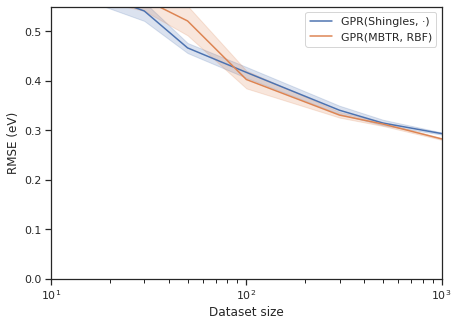

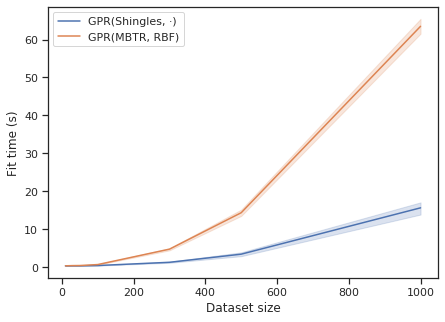

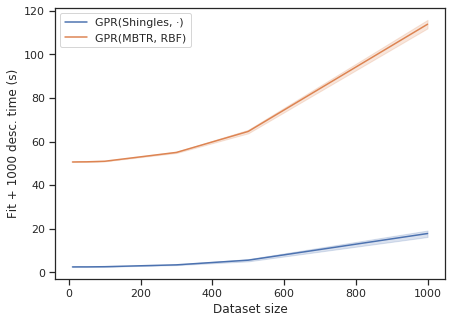

In [17]:
plot_data_efficiency(results_dict, desc_times_1000)

In [18]:
display_times(results_dict, desc_times_100, desc_times_500, desc_times_1000)

Experiment  Dataset size  Mean fit time  MM + desc time
0   GPR(Shingles, ·)            10       0.248157             NaN
1     GPR(MBTR, RBF)            10       0.270714             NaN
2   GPR(Shingles, ·)            30       0.269964             NaN
3     GPR(MBTR, RBF)            30       0.325344             NaN
4   GPR(Shingles, ·)            50       0.265122             NaN
5     GPR(MBTR, RBF)            50       0.345536             NaN
6   GPR(Shingles, ·)           100       0.347010        0.259027
7     GPR(MBTR, RBF)           100       0.602693        4.698979
8   GPR(Shingles, ·)           300       1.198670             NaN
9     GPR(MBTR, RBF)           300       4.669717             NaN
10  GPR(Shingles, ·)           500       3.344808        1.176772
11    GPR(MBTR, RBF)           500      14.291329       25.920590
12  GPR(Shingles, ·)          1000      15.579025        2.208287
13    GPR(MBTR, RBF)          1000      63.515543       50.360356